In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

rng = np.random.RandomState(42)

## Generate some data

In this notebook, we study the internal mechanism used by decision tree to make some classification.

We start by creating a dataset made of 200 samples and a single feature. These samples are equally split into 2 classes following some normal distribution.

In [2]:
n_class_samples = 100
X = np.hstack(
    [rng.randn(n_class_samples), 2.5 + rng.randn(n_class_samples)]
).T
y = np.array([0] * n_class_samples + [1] * n_class_samples)

To ease some later processing, we are sorting our data.

In [3]:
sorted_idx = np.argsort(X)
X = X[sorted_idx]
y = y[sorted_idx]

We can give a look at the class distribution of the dataset.

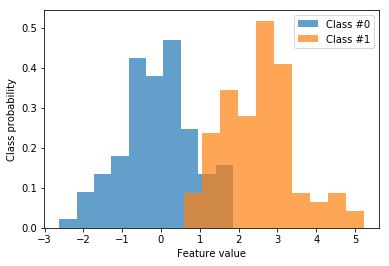

In [4]:
for clazz in np.unique(y):
    plt.hist(X[y==clazz], alpha=0.7, label=f'Class #{clazz}', density=True)
plt.legend()
plt.xlabel('Feature value')
plt.ylabel('Class probability');

Since we have only few samples, we can use a `swarmplot` to visualize all samples of the dataset.

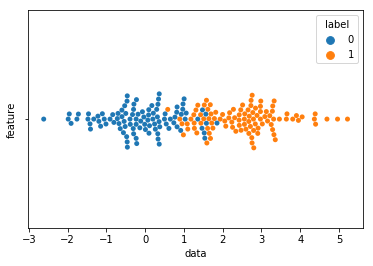

In [5]:
df = pd.DataFrame({'data': X, 'label': y, 'feature': ""})
_ = sns.swarmplot(x='data', y='feature', hue='label', data=df)

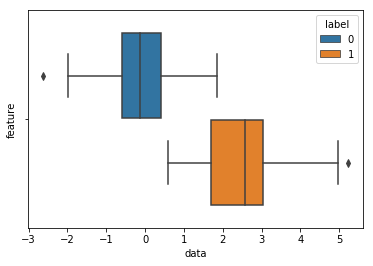

In [7]:
_ = sns.boxplot(x='data', y='feature', hue='label', data=df)

## Definition of some concepts: probabilities, entropy and information gain

Decision trees for classification are based on the following concepts: probabilities, entropy, and information gain. We present those concepts and describe where they come into play in the classification procedure.

### Ultimate objective: find the best split

Our goal is to find a threshold which best split the dataset. In other words, we want the boundary such that most samples smaller than this boundary belong to a class and most samples above this boundary belong to the counterpart class. Let's visualise what we mean.

In [8]:
random_idx = rng.choice(np.arange(y.size))

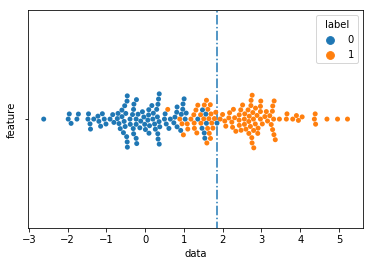

In [9]:
ax = sns.swarmplot(x='data', y='feature', hue='label', data=df)
_ = ax.plot([X[random_idx], X[random_idx]], [-1, 1], '-.')

In the above example, we, therefore, expect as much as possible blue samples on the left of the decision boundary and as much as possible orange samples on the right of the decision boundary.

Thus, we need to compute some statistics characteristic the quality of this split, sometimes called impurity. Let's group the labels into two groups, all labels corresponding to the samples on the left of the boundary and all labels corresponding to the samples on the right.

In [10]:
labels_left = y[:random_idx]
labels_right = y[random_idx:]

### Probabilities

Impurity is related to the number of samples of each class on a side of the boundary. We can compute the probability which is the number of samples of a class on the total number of samples.

In [11]:
from collections import Counter
def compute_probability(labels):
    counter = Counter(labels)
    n_samples = sum(counter.values())
    return {clazz: count_clazz / n_samples for clazz, count_clazz in counter.items()}

Therefore, for the previous split, we could compute the probabilities for each class on the left and right side of the boundary.

In [12]:
prob_left = compute_probability(labels_left)
prob_right = compute_probability(labels_right)

In [13]:
print(f'Probability on the left split {prob_left}')
print(f'Probability on the right split {prob_right}')

Probability on the left split {0: 0.7674418604651163, 1: 0.23255813953488372}
Probability on the right split {0: 0.014084507042253521, 1: 0.9859154929577465}


Those results make sense. On the right side of the boundary, there is mainly orange samples meaning a very high probability for class #1 and a small probability for the blue class (class #0).

On the right side of the boundary, the probabilities are less extreme with samples belonging to both classes

Therefore, we can build the intuition that we need a split which will have a maximum probability for the class #0 on the left side of the split and a maximum probability for the class #1 for the right side of the split.

### Entropy

In the previous section, we computed probabilities. It gives several statistics depending on the class, and it will be handy to get a single statistic which characterises the impurity of a side of the boundary: we will use the entropy definition.

Entropy is defined: $H(X) = - \sum_{k=1}^{K} p(X_k) \log_{2} p(X_k)$, where $K$ is the number of classes. In practise the entropy function looks like:

![title](https://upload.wikimedia.org/wikipedia/commons/2/22/Binary_entropy_plot.svg)

Considering some labels, the entropy will be maximum if there are as many samples from one class than another. It will be minimum when there are only samples from a single class.

In [14]:
def entropy(labels):
    probabilities = compute_probability(labels)
    return - sum([prob * np.log2(prob) for prob in probabilities.values()])

We can compute the entropy for each side of the split.

In [15]:
entropy_left = entropy(labels_left)
entropy_right = entropy(labels_right)

In [16]:
print(f'Entropy on the left split {entropy_left}')
print(f'Entropy on the right split {entropy_right}')

Entropy on the left split 0.782444129406689
Entropy on the right split 0.10679203237584187


We see that the entropy on the right side is minimum. We only had orange samples on that side. The entropy of the right side is closer to one because we have almost half-half orange and blue samples.

### Information gain

For the current split, we currently have two statistics, an entropy for each side of the split. It will be handy to get a single statistic to summarise the quality of the split. It is called the information gain.

Indeed, the information gain corresponds to the entropy computed before splitting the data to which we subtract the entropy from the right and left side of the split (with some additional normalisation factor).

In [17]:
def information_gain(labels_parent, labels_left, labels_right):
    entropy_parent = entropy(labels_parent)
    entropy_left = entropy(labels_left)
    entropy_right = entropy(labels_right)
    return (entropy_parent - 
            (labels_left.size / labels_parent.size) * entropy_left -
            (labels_right.size / labels_parent.size) * entropy_right)

In [18]:
info_gain_split = information_gain(y, labels_left, labels_right)

In [19]:
print(f'Information for the current {info_gain_split}')

Information for the current 0.4574123650392617


## Meaning of information gain

This metric is called information gain because it relates to the gain in "purity" obtained by partitioning the data. We can try several random partitions and see that a higher is the gain corresponds to a better split to partition the two classes.

In [25]:
random_idx = rng.choice(np.arange(y.size))

In [26]:
labels_left = y[:random_idx]
labels_right = y[random_idx:]

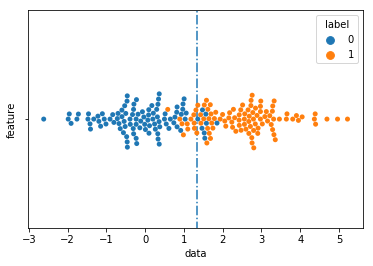

In [27]:
ax = sns.swarmplot(x='data', y='feature', hue='label', data=df)
_ = ax.plot([X[random_idx], X[random_idx]], [-1, 1], '-.')

In [28]:
info_gain_split = information_gain(y, labels_left, labels_right)

In [29]:
print(f'Information for the current {info_gain_split}')

Information for the current 0.5483031156312098


## Greedy search for the maximum information gain

Instead of trying to random split, we can use a greedy strategy by iteratively trying all possible value and use the one maximum the information gain.

In [30]:
all_info_gain = [information_gain(y, y[:idx], y[idx:]) for idx in range(y.size)]

In [31]:
argmax_info_gain = np.argmax(all_info_gain)

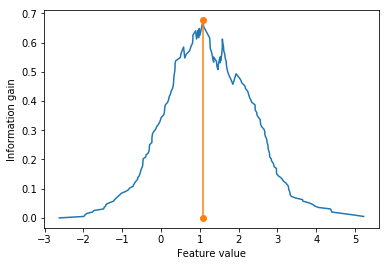

In [32]:
plt.plot(X, all_info_gain)
plt.plot([X[argmax_info_gain], X[argmax_info_gain]],
         [all_info_gain[argmax_info_gain], 0],
         marker='o', label='Best split')
plt.xlabel('Feature value')
_ = plt.ylabel('Information gain')

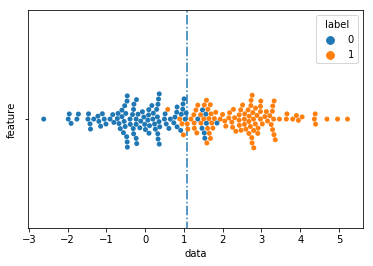

In [33]:
ax = sns.swarmplot(x='data', y='feature', hue='label', data=df)
_ = ax.plot([X[argmax_info_gain], X[argmax_info_gain]], [-1, 1], '-.')

In [34]:
print(f'Information for the current {all_info_gain[argmax_info_gain]}')
print(f'Feature value for this split {X[argmax_info_gain]}')

Information for the current 0.676609846352858
Feature value for this split 1.0846292579495858


## Exercise

**Use a `sklearn.tree.DecisionTreeClassifier` to classifiy the data `X` and `y`. Train the decision tree. Ensure to use the good criterion and to limit the depth of the tree to get a similar process than what we did before.**

In [35]:
X = X[:, np.newaxis]

In [38]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='entropy', max_depth=1)
tree.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

Once this classifier is trained, we can plot the resulting decision and compare it with the previous procedure.

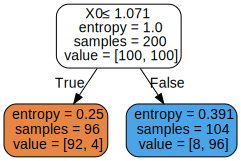

In [39]:
import graphviz  # requires to install graphviz and python-graphviz - available in conda
from sklearn.tree import export_graphviz

dot_data = export_graphviz(
    tree, out_file=None, filled=True, rounded=True, special_characters=True
)  
graph = graphviz.Source(dot_data)  
graph 

In [40]:
print(f'Feature value for this split {(X[argmax_info_gain - 1] + X[argmax_info_gain]) / 2}')

Feature value for this split [1.07087574]


**Increase the depth of the tree and check how it changes the tree representation.**

In [ ]:
# Redefine the tree instance here

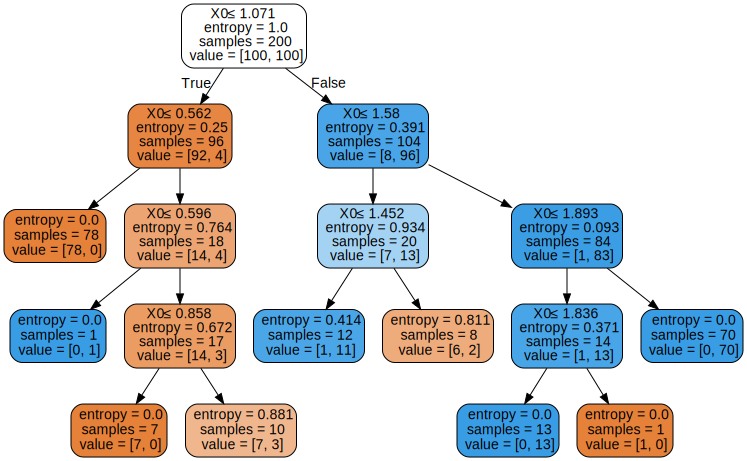

In [47]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=None,
                              min_impurity_decrease=0.01)
tree.fit(X, y)
dot_data = export_graphviz(
    tree, out_file=None, filled=True, rounded=True, special_characters=True
)  
graph = graphviz.Source(dot_data)  
graph 